# Data Prerparatinon

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import os

import math


from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import datetime as dt

2023-03-25 13:39:52.699432: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-25 13:39:52.761141: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-25 13:39:52.762151: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-25 13:39:53.616152: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

fname = 'final_dataset22.csv'

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
lines.pop()

header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))

['', 'Unnamed: 0', 'datetime', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'qav', 'num_trades', 'taker_base_vol', 'taker_quote_vol', 'ignore', 'ao', 'kama', 'ppo', 'pvo', 'roc', 'rsi', 'stochrsi', 'stoch', 'tsi', 'uo', 'wri', 'accdist', 'cmf', 'emv', 'fi', 'mfi', 'nvi', 'obv', 'smaemv', 'vpt', 'vwap', 'atr', 'ulcer', 'bbh', 'bbl', 'bbhi', 'bbli', 'bbmavg', 'bb_pb', 'bb_wb', 'dchb', 'dclb', 'dcmb', 'dcpb', 'dcwb', 'kchb', 'kclb', 'kchbi', 'kclbi', 'kcmb', 'kcpb', 'kcwb', 'adx', 'adx_neg', 'adx_pos', 'aroon_up', 'aroon_down', 'cci', 'dpo', 'kst', 'kst_sig', 'ema', 'ichimoku_a', 'ichimoku_b', 'ichimoku_base_line', 'ichimoku_conversion_line', 'macd', 'macd_diff', 'macd_signal', 'mi', 'sma', 'wma', 'stc', 'trix', 'psar_down_indicator', 'psar_up_indicator', 'vi_pos', 'vi_neg', 'ALU', 'WHEAT', 'XCU', 'BRENTOIL', 'COFFEE', 'SOYBEAN', 'NG', 'NI', 'RICE', 'XAU', 'IRD', 'SUGAR', 'ETHANOL', 'CORN', 'COTTON', 'TIN', 'ZNC']
525530


In [3]:
close = np.zeros( (len(lines),1) )
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    #print(values)
    close[i] = values[5]
    raw_data[i, :] = values[:]
        


In [4]:
num_train_samples = int(0.5 * len(raw_data))  # Train
num_val_samples = int(0.25 * len(raw_data))   # Validation
num_test_samples = len(raw_data) - num_train_samples - num_val_samples  # Test
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 262765
num_val_samples: 131382
num_test_samples: 131383


In [5]:


# delay: time in future that will be predicted
# we want to predict 12 hours in the future
delay = 6 * 60


# sequence length: sequence lenght of each sample
sequence_length = delay * 2 * 3


# sequence_stride: period between sequences
# First sequence starts at t0
# Second sequence will start at t1 with sequence_stride=1 or at t5 with sequence_stride=5
sequence_stride = 30


# sampling rate: period between timesteps within the sequence
# Sequence with rate=1 : t1,t2...tn
# Sequence with rate=3 : t1,t3...tn*3
sampling_rate = 5

#batch_size: Number of timeseries samples in each batch (except maybe the last one). 
#If None, the data will not be batched (the dataset will yield individual samples).
# Huge impact in performance.
# Tip, should be multiple of 8
batch_size = 64

# Understanding our parameters
msg = f"The timeseries will consist of batches containing {batch_size} sequences of {sequence_length} samples."

msg += f"\nFinally our target is {delay} timesteps in the future"
print(msg)

The timeseries will consist of batches containing 64 sequences of 2160 samples.
Finally our target is 360 timesteps in the future


In [6]:

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=True, # Shouldn't the shuffle be set to 0?
                    seed=33,
                    batch_size=batch_size,
                    start_index=0,
                    end_index=num_train_samples)

print("Done Train")


val_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=True,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples,
                    end_index=num_train_samples + num_val_samples)

print("Done Validation")      
      
test_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=True,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples + num_val_samples)

print("Done Test")

Done Train
Done Validation
Done Test


In [7]:
type(train_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [8]:

for samples, targets in train_dataset:
    print("samples_shape:", samples.shape)
    print("targets shape:", targets.shape)
    break
    
i =0
for samples, targets in train_dataset:
    i=i+1
    
print(i)

2023-03-25 13:40:17.513095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [8399]
	 [[{{node Placeholder/_28}}]]
2023-03-25 13:40:17.513720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [262765,1]
	 [[{{node Placeholder/_20}}]]


samples_shape: (64, 2160, 98)
targets shape: (64, 1)
132


# First ML Model

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(8, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("C:/models/first_model", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,epochs=10,validation_data=val_dataset,callbacks=callbacks)

model = keras.models.load_model("C:/models/first_model")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
132/132 [==============================] - ETA: 0s - loss: 200303662731488133120.0000 - mae: 13650196480.0000

INFO:tensorflow:Assets written to: C:/models/first_model/assets


INFO:tensorflow:Assets written to: C:/models/first_model/assets


132/132 [==============================] - 13s 94ms/step - loss: 200303662731488133120.0000 - mae: 13650196480.0000 - val_loss: 177063470173140287488.0000 - val_mae: 13288946688.0000
Epoch 2/10
131/132 [============================>.] - ETA: 0s - loss: 128207928834215903232.0000 - mae: 10365675520.0000

INFO:tensorflow:Assets written to: C:/models/first_model/assets


INFO:tensorflow:Assets written to: C:/models/first_model/assets


132/132 [==============================] - 12s 87ms/step - loss: 128272835204626776064.0000 - mae: 10368894976.0000 - val_loss: 111893744737182547968.0000 - val_mae: 10500632576.0000
Epoch 3/10
132/132 [==============================] - ETA: 0s - loss: 96960661593845137408.0000 - mae: 8999841792.0000

INFO:tensorflow:Assets written to: C:/models/first_model/assets


INFO:tensorflow:Assets written to: C:/models/first_model/assets


132/132 [==============================] - 11s 81ms/step - loss: 96960661593845137408.0000 - mae: 8999841792.0000 - val_loss: 62424794657214955520.0000 - val_mae: 7676594688.0000
Epoch 4/10
130/132 [============================>.] - ETA: 0s - loss: 73351772000378421248.0000 - mae: 7812266496.0000

INFO:tensorflow:Assets written to: C:/models/first_model/assets


INFO:tensorflow:Assets written to: C:/models/first_model/assets


132/132 [==============================] - 11s 84ms/step - loss: 73267215158155935744.0000 - mae: 7807952896.0000 - val_loss: 29613392961495629824.0000 - val_mae: 4934441472.0000
Epoch 5/10
132/132 [==============================] - ETA: 0s - loss: 54004602670311014400.0000 - mae: 6675083776.0000

INFO:tensorflow:Assets written to: C:/models/first_model/assets


INFO:tensorflow:Assets written to: C:/models/first_model/assets


132/132 [==============================] - 11s 85ms/step - loss: 54004602670311014400.0000 - mae: 6675083776.0000 - val_loss: 13486784448649232384.0000 - val_mae: 3418880000.0000
Epoch 6/10
132/132 [==============================] - 11s 79ms/step - loss: 38603716911773515776.0000 - mae: 5591519744.0000 - val_loss: 13748862940734291968.0000 - val_mae: 2710541824.0000
Epoch 7/10
132/132 [==============================] - 11s 82ms/step - loss: 26870254386706120704.0000 - mae: 4590139392.0000 - val_loss: 29816057143750557696.0000 - val_mae: 3835387648.0000
Epoch 8/10
132/132 [==============================] - 12s 90ms/step - loss: 18438148091803598848.0000 - mae: 3673770752.0000 - val_loss: 59561969843695517696.0000 - val_mae: 6087969792.0000
Epoch 9/10
132/132 [==============================] - 11s 83ms/step - loss: 13058513674514202624.0000 - mae: 2984853760.0000 - val_loss: 95147382201689047040.0000 - val_mae: 8243742208.0000
Epoch 10/10
132/132 [==============================] - 11s 81

2023-03-25 13:51:15.688662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [131023,1]
	 [[{{node Placeholder/_20}}]]
2023-03-25 13:51:15.689599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [4008]
	 [[{{node Placeholder/_28}}]]


63/63 [==============================] - 3s 46ms/step - loss: 18671844890240876544.0000 - mae: 3950530560.0000
Test MAE: 3950530560.00


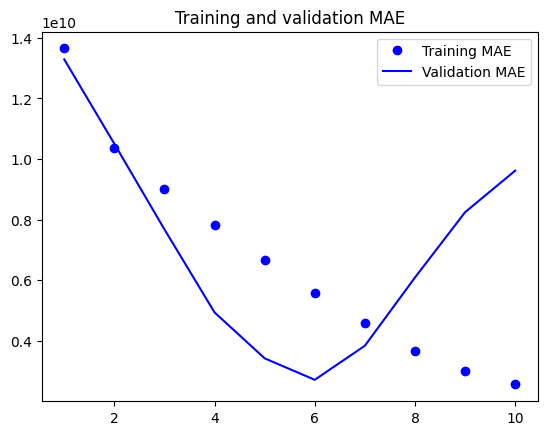

In [13]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# RNN 

In [14]:

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("C:/models/lstm",
   save_best_only=True)
]


model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10


2023-03-25 13:51:19.492667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-25 13:51:19.494508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-25 13:51:19.495941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

132/132 [==============================] - ETA: 0s - loss: 1446401536.0000 - mae: 37406.7422

2023-03-25 13:52:41.912984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-25 13:52:41.915353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-25 13:52:41.917124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: C:/models/lstm/assets


INFO:tensorflow:Assets written to: C:/models/lstm/assets


132/132 [==============================] - 101s 748ms/step - loss: 1446401536.0000 - mae: 37406.7422 - val_loss: 462859904.0000 - val_mae: 21448.8691
Epoch 2/10
132/132 [==============================] - ETA: 0s - loss: 1446344192.0000 - mae: 37405.9727

2023-03-25 13:54:34.864255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-25 13:54:34.866212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-25 13:54:34.867769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: C:/models/lstm/assets


INFO:tensorflow:Assets written to: C:/models/lstm/assets


132/132 [==============================] - 98s 744ms/step - loss: 1446344192.0000 - mae: 37405.9727 - val_loss: 462827008.0000 - val_mae: 21448.0996
Epoch 3/10
132/132 [==============================] - ETA: 0s - loss: 1446286848.0000 - mae: 37405.2148

2023-03-25 13:56:13.747821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-25 13:56:13.749653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-25 13:56:13.751103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: C:/models/lstm/assets


INFO:tensorflow:Assets written to: C:/models/lstm/assets


132/132 [==============================] - 99s 747ms/step - loss: 1446286848.0000 - mae: 37405.2148 - val_loss: 462794112.0000 - val_mae: 21447.3320
Epoch 4/10
132/132 [==============================] - ETA: 0s - loss: 1446229504.0000 - mae: 37404.4336

2023-03-25 13:57:52.801863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-25 13:57:52.803908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-25 13:57:52.805404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: C:/models/lstm/assets


INFO:tensorflow:Assets written to: C:/models/lstm/assets


132/132 [==============================] - 99s 750ms/step - loss: 1446229504.0000 - mae: 37404.4336 - val_loss: 462761312.0000 - val_mae: 21446.5605
Epoch 5/10
132/132 [==============================] - ETA: 0s - loss: 1446172032.0000 - mae: 37403.6758

2023-03-25 13:59:32.192134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-25 13:59:32.193934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-25 13:59:32.195421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: C:/models/lstm/assets


INFO:tensorflow:Assets written to: C:/models/lstm/assets


132/132 [==============================] - 100s 755ms/step - loss: 1446172032.0000 - mae: 37403.6758 - val_loss: 462728448.0000 - val_mae: 21445.7969
Epoch 6/10
132/132 [==============================] - ETA: 0s - loss: 1446115200.0000 - mae: 37402.9062

2023-03-25 14:01:11.304963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-25 14:01:11.307002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-25 14:01:11.308500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: C:/models/lstm/assets


INFO:tensorflow:Assets written to: C:/models/lstm/assets


132/132 [==============================] - 98s 745ms/step - loss: 1446115200.0000 - mae: 37402.9062 - val_loss: 462695552.0000 - val_mae: 21445.0352
Epoch 7/10
132/132 [==============================] - ETA: 0s - loss: 1446057856.0000 - mae: 37402.1406

2023-03-25 14:02:50.410488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-25 14:02:50.412336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-25 14:02:50.413791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: C:/models/lstm/assets


INFO:tensorflow:Assets written to: C:/models/lstm/assets


132/132 [==============================] - 99s 750ms/step - loss: 1446057856.0000 - mae: 37402.1406 - val_loss: 462662656.0000 - val_mae: 21444.2656
Epoch 8/10
132/132 [==============================] - ETA: 0s - loss: 1446000512.0000 - mae: 37401.3750

2023-03-25 14:04:29.650954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-25 14:04:29.652940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-25 14:04:29.654376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: C:/models/lstm/assets


INFO:tensorflow:Assets written to: C:/models/lstm/assets


132/132 [==============================] - 100s 755ms/step - loss: 1446000512.0000 - mae: 37401.3750 - val_loss: 462629632.0000 - val_mae: 21443.4941
Epoch 9/10
132/132 [==============================] - ETA: 0s - loss: 1445943168.0000 - mae: 37400.6016

2023-03-25 14:06:08.558875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-25 14:06:08.560983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-25 14:06:08.562460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: C:/models/lstm/assets


INFO:tensorflow:Assets written to: C:/models/lstm/assets


132/132 [==============================] - 98s 745ms/step - loss: 1445943168.0000 - mae: 37400.6016 - val_loss: 462596864.0000 - val_mae: 21442.7305
Epoch 10/10
132/132 [==============================] - ETA: 0s - loss: 1445885440.0000 - mae: 37399.8398

2023-03-25 14:07:47.725615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-25 14:07:47.727493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-25 14:07:47.728971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: C:/models/lstm/assets


INFO:tensorflow:Assets written to: C:/models/lstm/assets


132/132 [==============================] - 99s 750ms/step - loss: 1445885440.0000 - mae: 37399.8398 - val_loss: 462564096.0000 - val_mae: 21441.9648


In [15]:
model = keras.models.load_model("C:/models/lstm")

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

2023-03-25 14:07:51.477314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-03-25 14:07:51.477489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-03-25 14:07:51.477608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

63/63 [==============================] - 15s 230ms/step - loss: 333402016.0000 - mae: 18189.2852
Test MAE: 18189.29


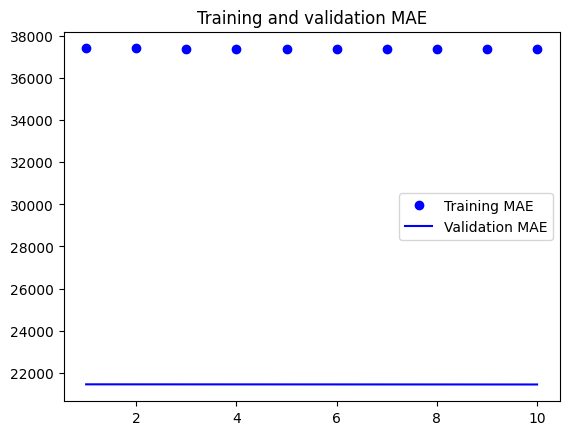

In [16]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()